# Autoencoders and unsupervised classification
In this notebook I show how autoencoders can be used in the solution of a simple version of the neural waveform sorting problem.  (It'*simple* because we're not trying to identify the same neuron on multiple electrodes.)  The idea is pretty simple.  The bottleneck layer of a trained autoencoder represents a (potentially enormous) dimensionality reduction of the input.  This dimensionality reduction is then used as the basis of waveform clustering using e.g. a Gaussian Mixture Model.  Traditionally, PCA or hand-coded features like energy have been used in the dimensionality reduction phase of clustering.  Here we can show that autoencoders result in measurable improvement in clustering quality relative to clustering based off the first components of PCA.

Matt Phillips, mattphillipsphd@gmail.com

## Part 1:
Getting the data and building a simple autoencoder

## Part 2:
Clustering, comparing to PCA

## Part 3:
Building a convolutional autoencoder.  Does that help in our case?


## Part 1: Getting waveform data and building a simple autoencoder
### 1.1 Basic setup

In [1]:
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import sklearn
import shutil
import tensorflow as tf

from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
from sklearn import mixture
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_samples

pj = os.path.join

%matplotlib inline

In [2]:
if os.name == "nt":
    LOG_DIR = "tf_graphs/multi"
    TRAIN_DIR = "J:/MLDataSets/Waveforms"
else:
    LOG_DIR = "tf_graphs/multi"
    TRAIN_DIR = "/home/matt/Data/Waveforms/"

file_ct = 0

In [3]:
conf = {}
conf["numh1"] = 10
conf["numh2"] = 3

conf["regularize"] = False
conf["num_epochs"] = 2000
conf["lambda"] = 0.1
conf["lr"] = 0.01
conf["momentum"] = 0.9

g_waves = None
g_num_waves = None
g_num_samps = None
g_color_list = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

## 1.2 Getting the data.
There are two steps required for this, **unless** you are content just to play with the data set that has been uploaded along with this repo, 010609_2.plx.data.  In that case, you can skip 1.2.1 and 1.2.2.  Just make sure to include the full reference from 1.2.1 below if you reuse the data anywhere on your own.

### 1.2.1 
The first step is to get waveform data from CRCNS.org, specifically

Christopher A. Buneo, Ying Shi, Gregory Apker, Paul VanGilder (2016). 
Multimodal spike data recorded from posterior parietal cortex of non-human primates performing a reaction-time task involving combined eye and arm movements while in a virtual reality environment. 
CRCNS.org.
http://dx.doi.org/10.6080/K0CZ353K

Downloaded from crcns.org/data-sets/pc/ppc-1, 8/5/2017.  Note, you will need an account to get the data there.  

### 1.2.2
The second step--which can be skipped if you have your own functionality for reading Plexon .plx files--is to download WaveSorter here:

https://sourceforge.net/projects/wavesorter/

and use it to read in one of the waveform sets from the data collection.  Perform any clustering, then hit File -> Save Spikes ... > Save All.  This will create a file which readWaveSorter() below can parse.

In [4]:
# This reads a WaveSorter .data file
def readWaveSorter(data_file):
    global g_waves, g_num_waves, g_num_samps
    with open(pj(TRAIN_DIR, data_file)) as fp:
        reader = csv.reader(fp, delimiter='\t')
        header = next(reader)
        g_num_waves = int( header[0] )
        g_num_samps = int( header[1] )
        next(reader)
        next(reader)
        next(reader)
        
        waves = []
        for row in reader:
            waves.append( list(map(float, row[7:])) )
    temp_waves = np.copy(waves)
    m = np.mean(temp_waves) 
    sd = np.std(temp_waves)
    g_waves = (temp_waves - m) / (3 * sd)

readWaveSorter("010609_2.plx.data")
#readWaveSorter("Neuron2.plx.data")

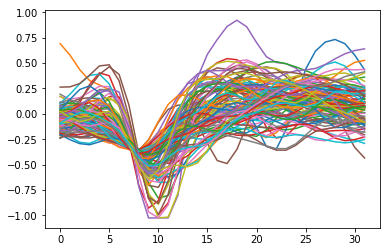

In [5]:
plt.figure()
for i in range(100):
    plt.plot(g_waves[i,:])

We include here a utility for graphing before/after waveforms. showExamples()  plots a handful of original waveforms (blue) overlaid with reconstructed waveforms (orange)

In [6]:
def showExamples(m, session):
    X = range(g_num_samps)
    nrows = 3
    ncols = 8
    fig, axs = plt.subplots(nrows,ncols, figsize=(2*ncols,2*nrows))
    inc = int(np.floor(len(g_waves) / (nrows*ncols)))
    for i in range(nrows*ncols):
        idx = i*inc+1
        if idx>len(g_waves):
            break
        w = g_waves[idx,:].reshape([1,g_num_samps])
        if "tensorflow" in type(m).__module__:
            what = m.eval(session=session, feed_dict={x : w})
        else:
            what = m[idx,:]
        ax = axs[i/ncols, i%ncols]
        ax.plot(X, w.transpose())
        ax.plot(X, what.transpose())
        ax.set_ylim([-2, 2])

## 1.3 Build a simple autoencoder
This is a feedforward network no skip connections and a total of 5 layers.  The middle layer has the fewest units and is the bottleneck layer.  As for the other layers, in terms of the number of units, the layers are mirror images of each other across the bottleneck layer.  Activation functions are sigmoids except for the output layer which is purely linear.
The dimensionality reduction is fundamentally controlled by the number of units in the bottleneck layer; additional regularization may be 'turned on' with the conf["regularize"] parameter.

### 1.3.1 Initialize the computational graph and create variables

In [7]:
tf.reset_default_graph()

It is convenient to create the weights and biases tensors en masse.

In [8]:
x = tf.placeholder(tf.float32, shape=(None, g_num_samps), name="x")

In [9]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([g_num_samps, conf["numh1"]])),
    'encoder_h2': tf.Variable(tf.random_normal([conf["numh1"], conf["numh2"]])),
    'decoder_h1': tf.Variable(tf.random_normal([conf["numh2"], conf["numh1"]])),
    'decoder_h2': tf.Variable(tf.random_normal([conf["numh1"], g_num_samps])),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([conf["numh1"]])),
    'encoder_b2': tf.Variable(tf.random_normal([conf["numh2"]])),
    'decoder_b1': tf.Variable(tf.random_normal([conf["numh1"]])),
    'decoder_b2': tf.Variable(tf.random_normal([g_num_samps])),
}

### 1.3.2 Create encoder and decoder layers
These are fully connected layers.  This step is very straightforward.

In [10]:
with tf.name_scope("encoder"):
    y1 = tf.matmul(x, weights["encoder_h1"]) + biases["encoder_b1"]
    h1 = tf.nn.sigmoid(y1, name="h1")
    
    y2 = tf.matmul(h1, weights["encoder_h2"]) + biases["encoder_b2"]
    h2 = tf.nn.sigmoid(y2, name="h2")
    
    tf.summary.histogram("h1", h1)
    tf.summary.histogram("h2", h2)


In [11]:
with tf.name_scope("decoder"):
    yd1 = tf.matmul(h2, weights["decoder_h1"]) + biases["decoder_b1"]
    hd1 = tf.nn.sigmoid(yd1, name="hd1")
    
    out = tf.matmul(hd1, weights["decoder_h2"]) + biases["decoder_b2"]
    
    tf.summary.histogram("hd1", hd1)
    tf.summary.histogram("out", out)


### 1.3.3 Define loss function and training operation

In [12]:
with tf.name_scope("ae_mse"):
    sq_error = tf.reduce_mean(np.square(out - x), axis=1, name="sq_error")
    if conf["regularize"]:
        reg = tf.multiply( conf["lambda"] * g_num_waves * g_num_waves, 
                          tf.reduce_mean(tf.square(h - 0.5)), name="reg")
        mse = tf.reduce_mean( sq_error + reg, name="mse" )
        tf.summary.scalar("sq_error", tf.reduce_mean( sq_error ))
        tf.summary.scalar("reg", tf.reduce_mean( reg ))
    else:   
        mse = tf.reduce_mean( sq_error, name="mse" )
    tf.summary.scalar("mse", mse)
    
with tf.name_scope("opt"):
    optimizer = tf.train.RMSPropOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.MomentumOptimizer(learning_rate=conf["lr"], momentum=conf["momentum"])
    training_op = optimizer.minimize(mse)

### 1.3.4 Run the session

3.86948
0.0555129
0.0328019
0.0257646
0.0207395
0.0171346
0.0160818
0.0167865
0.014766
0.0141921
0.0148952
0.0152169
0.0138915
0.0125611
0.0145073
0.0131787
0.0115144
0.0114077
0.0132609
0.0119723


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


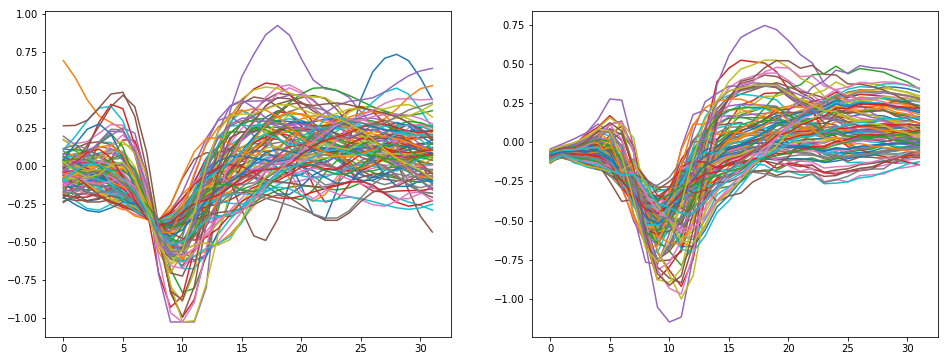

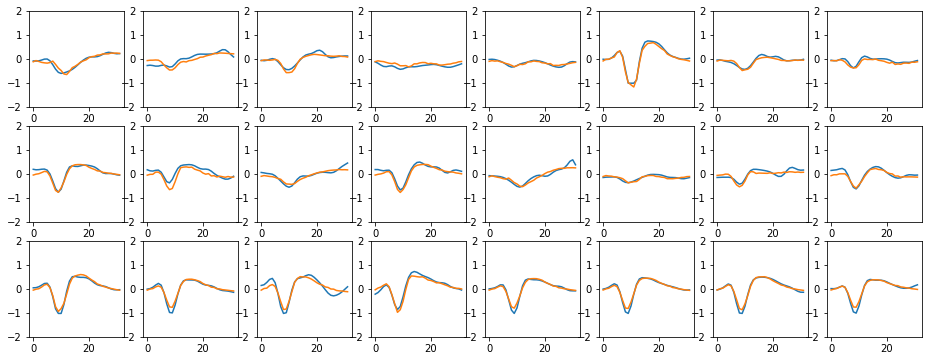

In [13]:
with tf.device("/gpu:0"):
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(pj(LOG_DIR, str(file_ct)), sess.graph)
    file_ct += 1

    for i in range(conf["num_epochs"]):
        summary,_ = sess.run([merged, training_op], feed_dict={x : g_waves})
        train_writer.add_summary(summary, i)
        if i%100 == 0:
            print(mse.eval(session=sess, feed_dict={x : g_waves}))

    fig, axs = plt.subplots(1,2, figsize=(16,6))
    waves_out = out.eval(session=sess, feed_dict={x : g_waves})
    X = range(g_num_samps)
    for i in range(100):
        axs[0].plot(X, g_waves[i,:])
        axs[1].plot(X,waves_out[i,:])
        
    showExamples(out, sess)

## Part 2: Visualize and cluster the data
We'll use a vanilla Gaussian Mixture model for clustering.  The quality of the clustering will be measured with the BIC (Bayesian Information Criterion).  This lets us compare how well an auto-encoder-based clustering does compared to PCA, a standard dimensionality reduction technique in neuroscience.

### 2.1 Create functions to fit data using a Gaussian Mixture Model and to measure quality of the fit

In [14]:
def fit_samples(samples, n_components=2, do_plot=False):
    gmix = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
    gmix.fit(samples)
    if do_plot:
        colors = [g_color_list[i] for i in gmix.predict(samples)]
        makeScatterMat(samples, colors)
    return gmix.predict(samples), gmix.means_

In [15]:
# This version of silhouette, with a Euclidean distance metric, is very crude.  In reality, different variances along different 
# should be accounted for
def silhouette(samples, labels):
    coeffs = silhouette_samples(samples, labels)
    clus_coeffs = []
    for i in list(set(labels)):
        clus_coeffs.append( np.mean( coeffs[labels==i] ) )
    return clus_coeffs

### 2.2 Use fit quality metric to find the best number of neurons for the clustering, for both AE and PCA

In [16]:
h_waves = h2.eval(session=sess, feed_dict={x : g_waves})

_pca = PCA(n_components=conf["numh2"])
_pca.fit(g_waves)
pca_waves = _pca.transform(g_waves)

h_rsq = 1 - np.sum(np.square(g_waves - waves_out)) / np.sum(np.square(g_waves))
print("Total variance explained by autoencoder reconstruction: %f" % h_rsq)

pca_rsq = sum(_pca.explained_variance_ratio_)
print("Total variance explained by first %d PCA components: %f" % \
      (conf["numh2"], pca_rsq))

Total variance explained by autoencoder reconstruction: 0.901082
Total variance explained by first 3 PCA components: 0.820832


In [17]:
max_num_neurons = 5
print("#\tAutoEnc\t\t\tPCA")
h_quals = []
pca_quals = []
for i in range(2, max_num_neurons+1):
    h_labels,_ = fit_samples(h_waves, i)
    h_qual = np.mean(silhouette(h_waves, h_labels))
        # We deliberately average unit means rather than take a grand average
    h_quals.append(h_qual)
        
    pca_labels,_ = fit_samples(pca_waves, i)
    pca_qual = np.mean(silhouette(pca_waves, pca_labels))
    pca_quals.append(pca_qual)
    
    print("%(i)d\t%(h_qual)f\t%(pca_qual)f" % locals())
    
if np.max(h_quals) > np.max(pca_quals):
    best_num = h_quals.index(np.max(h_quals)) + 2
else:
    best_num = pca_quals.index(np.max(pca_quals)) + 2
    
# TODO!!! Get the right quality metric
best_num = 3
    
# This doesn't take too long so we'll just redo it
h_labels,_ = fit_samples(h_waves, best_num)
pca_labels,_ = fit_samples(pca_waves, best_num)

#	AutoEnc			PCA
2	0.469050	0.442952
3	0.248381	0.391584
4	0.314993	0.294447
5	0.306881	0.209791


### 2.3 Plot clusterings and sorted waveforms from both analyses

In [18]:
def makeScatterMat(m, colors=[], name="v", title=""):
    columns = []
    for i in range( int( m.shape[1] ) ):
        columns.append(name + "_" + str(i+1))
    if "tensorflow" in type(m).__module__:
        arr = m.eval(session=sess, feed_dict={x : g_waves})
    else:
        arr = m
    if len(colors)==0:
        colors = 'b' * arr.shape[0]
    df = DataFrame(arr, columns=columns)
    scatter_matrix(df, alpha=0.1, c=colors, figsize=(16,16))

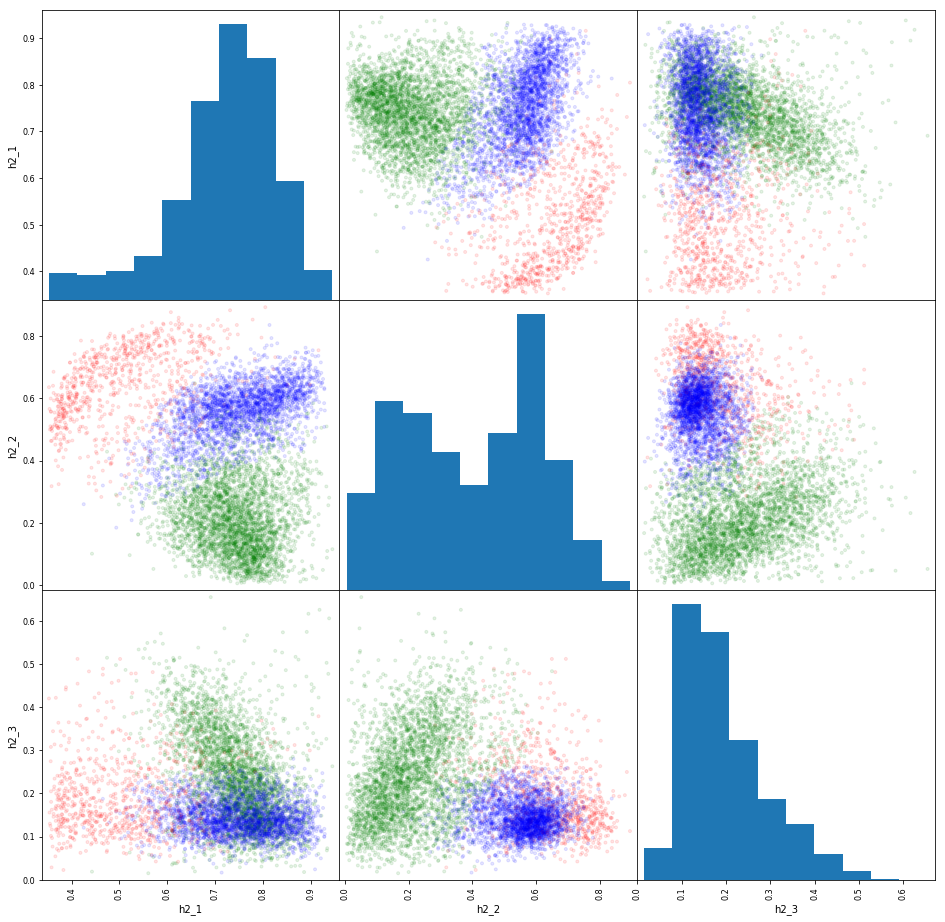

In [19]:
makeScatterMat(h_waves, [g_color_list[h_labels[i]] for i in range(g_num_waves)], "h2", "Autoencoder")

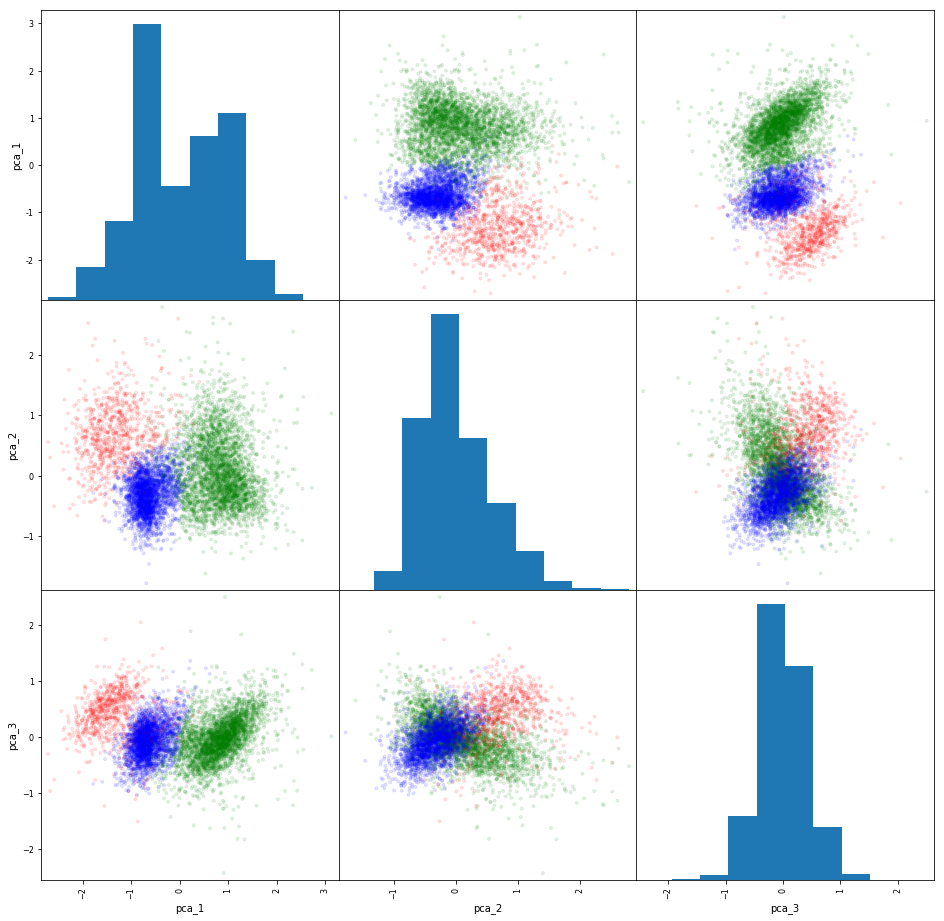

In [20]:
makeScatterMat(pca_waves, [g_color_list[h_labels[i]] for i in range(g_num_waves)], "pca", "PCA")

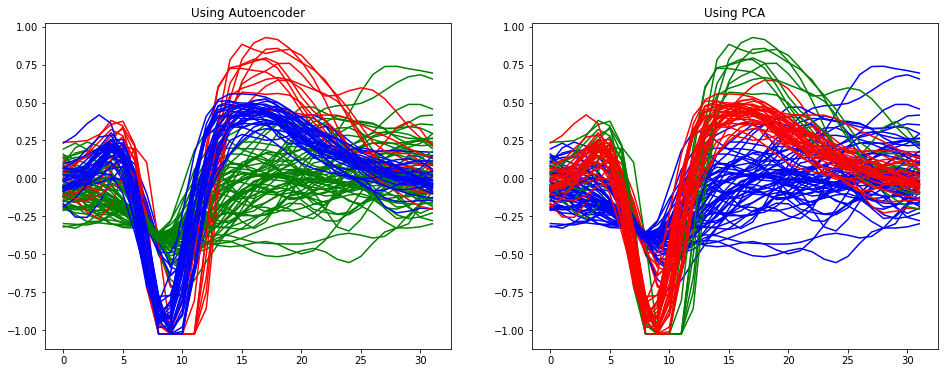

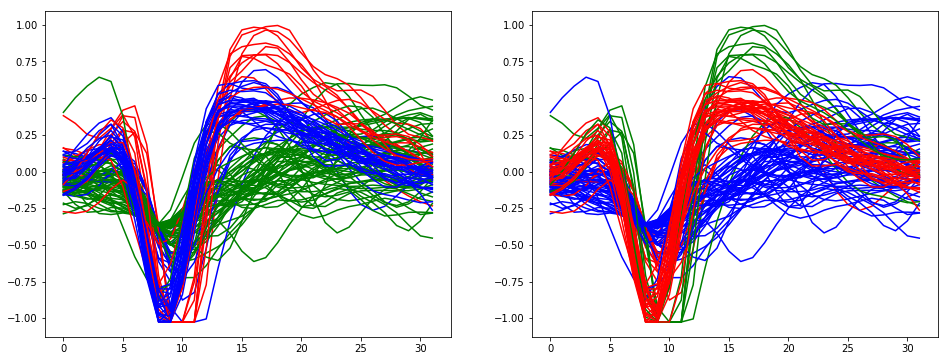

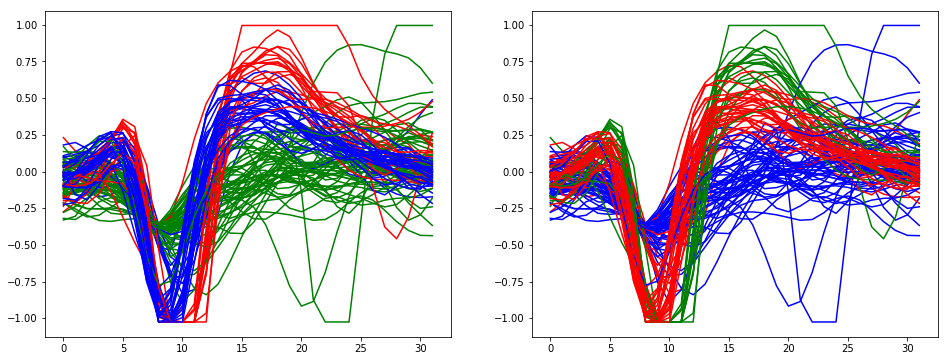

In [21]:
X = range(g_num_samps)
inc = int(np.floor(g_num_waves / 110))

def makeCompareFigs(inc_offset):
    fig, axs = plt.subplots(1,2, figsize=(16,6))
    for i in range(100):
        idx = i*inc + inc_offset
        axs[0].plot(X, g_waves[idx,:], color=g_color_list[h_labels[idx]])
        axs[1].plot(X, g_waves[idx,:], color=g_color_list[pca_labels[idx]])
    if inc_offset==0:
        axs[0].set_title("Using Autoencoder")
        axs[1].set_title("Using PCA")
        
makeCompareFigs(0)
makeCompareFigs(1)
makeCompareFigs(2)

**Summary**: It's not surprising that an autoencoder-based clustering does better than a PCA-based clustering; it has much more freedom to create a transformation which will enable a low-dimensional representation of the original data.  However, it is non-obvious that such a simple autoencoder would perform visibly, measurably better on ephys data chosen essentially at random.  This is what has happened.

In [22]:
def write_out(h_out):
    with open(pj(TRAIN_DIR, "ae_data.txt"), "w", newline='') as fp:
        writer = csv.writer(fp, delimiter='\t')
#        header = list(h_out.shape) + ["t"]
        header = [h_out.shape[0], 12] + ["t"]
        writer.writerow(header)
        for i in range(h_out.shape[0]):
            row = [i] + list(h_out[i,:]) + list(np.random.rand(8))
            writer.writerow(row)
            
write_out(h_out)

NameError: name 'h_out' is not defined

## Part 3: Building a convolutional autoencoder
Under construction, check back soon.